In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
! pip install evaluate

In [8]:
! pip install -U accelerate
! pip install -U transformers

# References
- https://towardsdatascience.com/the-ultimate-guide-to-training-bert-from-scratch-final-act-eab78b0657bb
- https://keras.io/examples/nlp/pretraining_BERT/

### LOAD LIBRARIES

In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 

import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')  

from transformers import BertTokenizer, DataCollatorForLanguageModeling, BertForPreTraining

import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import random
import evaluate
import logging

import datetime
from datetime import date

import torch
import accelerate

accelerate.__version__


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'0.29.3'

### GLOBAL VARIABLES

In [10]:
RANDOM_SEED = 42

#https://www.researchgate.net/publication/345395208_BERTimbau_Pretrained_BERT_Models_for_Brazilian_Portuguese
BLOCK_SIZE = 256  # Maximum number of tokens in an input sample
NSP_PROB = 0.50  # Probability that the next sentence is the actual next sentence in NSP ##=> Segun BERT
SHORT_SEQ_PROB = 0.1  # (10% de las veces vamos a usar secuencias cortas) Probability of generating shorter sequences to minimize the mismatch between pretraining and fine-tuning.
MAX_LENGTH = 512  # Maximum number of tokens in an input sample after padding

MLM_PROB = 0.15  # Probability with which tokens are masked in MLM ##=> BERTimbau 0.15

# Entrenaniento
TRAIN_BATCH_SIZE = 64  # Batch-size for pretraining the model on ##=> BERTimbau base 128
EVAL_BATCH_SIZE = 64
MAX_EPOCHS = 40  # Maximum number of epochs to train the model for
LEARNING_RATE = 1e-4#2e-5  # Learning rate for training the model ##=> BERTimbau base 1e-4
WEIGHT_DECAY = 0.01

# Early stopping
ES_PATIENCE = 5
ES_THRESHOLD = 0.001

PATH_DATASET = "../../dataset/df_selfsupervised_90porcent_utlcapps_2024-02-17.csv"
PATH_RESULT_MODEL = './result/code_selfsupervised_BERTimabauBase-UTLCapps-1lastlayersdefreeze-LR1e4/'

# Modelo
MODEL_CHECKPOINT = "neuralmind/bert-base-portuguese-cased"  # Name of pretrained model from 🤗 Model Hub

In [11]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### SELECT GPU

In [12]:
print(f"CUDA disponible: {torch.cuda.is_available()}")
print(f"Versión de CUDA: {torch.version.cuda}")

CUDA disponible: True
Versión de CUDA: 12.1


In [13]:
print("Número de GPUs disponibles:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Número de GPUs disponibles: 1
GPU 0: NVIDIA A100 80GB PCIe


In [14]:
# Put the GPU I want
torch.cuda.set_device(0) #GPU-1
# Para ver si esta utilizando GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#GPU usado actualmente
id_gpu = torch.cuda.current_device()
print(device,': GPU-',id_gpu)

cuda : GPU- 0


### LOAD DATA

In [16]:
df_b2w = pd.read_csv(PATH_DATASET)
print(df_b2w.shape)
df_b2w.head(10)

(671911, 2)


,review,label
0,Idiotas. O aplicativo custou muito caro para a...,1.0
1,"Joguei a placa de um carro que deve 400,000 em...",0.0
2,"rápido, prático e eficiente,ficaria melhor se ...",1.0
3,poderia colocar uma página de gastos online e ...,1.0
4,Essencial uso cotidiano 2019 melhor ainda,1.0
5,Só faltam os mayorships,1.0
6,É muito bom o YouTube não tem quem fique sem e...,1.0
7,"Ótimo aplicativo, tem todas as linhas e horári...",1.0
8,e uma posta,0.0
9,"Porra mano esse aplicativo é muito foda, eu só...",1.0


In [17]:
# Contar las palabras por fila, maximo, minimo y media
def count_words_nltk(texto):
    words = word_tokenize(texto)
    cant_words = len(words)
    return cant_words
cant_words = [ count_words_nltk(sentence) for sentence in df_b2w['review'] ]

In [18]:
# Calcular la media, el mínimo y el máximo
media = np.mean(cant_words)
minimo = np.min(cant_words)
maximo = np.max(cant_words)
# Imprimir los resultados
print("Media:", media)
print("Mínimo:", minimo)
print("Máximo:", maximo)

Media: 17.310152683912005
Mínimo: 1
Máximo: 612


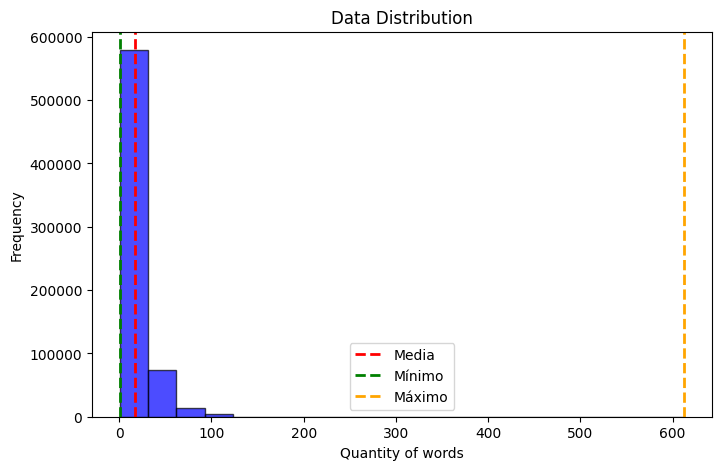

In [19]:
plt.figure(figsize=(8, 5))
plt.hist(cant_words, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.axvline(media, color='red', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(minimo, color='green', linestyle='dashed', linewidth=2, label='Mínimo')
plt.axvline(maximo, color='orange', linestyle='dashed', linewidth=2, label='Máximo')
plt.xlabel('Quantity of words')
plt.ylabel('Frequency')
plt.title('Data Distribution')
plt.legend()
plt.show()

In [20]:
# Convertir todas las palabras a minusculas ya que para nuestros objetivos no sera necesario diferenciar entre mayusculas y minusculas
df_b2w['review'] = [sentence.lower() for sentence in df_b2w['review']]
df_b2w.head()

,review,label
0,idiotas. o aplicativo custou muito caro para a...,1.0
1,"joguei a placa de um carro que deve 400,000 em...",0.0
2,"rápido, prático e eficiente,ficaria melhor se ...",1.0
3,poderia colocar uma página de gastos online e ...,1.0
4,essencial uso cotidiano 2019 melhor ainda,1.0


### SPLIT DATA INTO TRAINING (80%) AND VALIDATION (20%)

In [21]:
x = pd.DataFrame()
x['text'] = df_b2w['review'].copy()
x_train, x_validation = train_test_split(x['text'], test_size=0.2, random_state=RANDOM_SEED)
# Resetear el índice para evitar que se incluya como una columna adicional
x_train = x_train.reset_index(drop=True)
x_validation = x_validation.reset_index(drop=True)

In [22]:
# Convertir a datasets
train_dataset = Dataset.from_pandas(pd.DataFrame(x_train, columns=['text']))
validation_dataset = Dataset.from_pandas(pd.DataFrame(x_validation, columns=['text']))

In [23]:
# Crear un DatasetDict con los dos conjuntos de datos
dataset_dict = DatasetDict({'train': train_dataset, 'validation': validation_dataset})
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 537528
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 134383
    })
})

### TRAINING NSP AND MLM

In [24]:
tokenizer = BertTokenizer.from_pretrained(MODEL_CHECKPOINT)

In [25]:
#######
# NSP
# We define the maximum number of tokens after tokenization that each training sample
# will have
max_num_tokens = BLOCK_SIZE - tokenizer.num_special_tokens_to_add(pair=True)

# Task NSP
def prepare_train_features(examples):

    """Function to prepare features for NSP task

    Arguments:
      examples: A dictionary with 1 key ("text")
        text: List of raw documents (str)
    Returns:
      examples:  A dictionary with 4 keys
        input_ids: List of tokenized, concatnated, and batched
          sentences from the individual raw documents (int)
        token_type_ids: List of integers (0 or 1) corresponding
          to: 0 for senetence no. 1 and padding, 1 for sentence
          no. 2
        attention_mask: List of integers (0 or 1) corresponding
          to: 1 for non-padded tokens, 0 for padded
        next_sentence_label: List of integers (0 or 1) corresponding
          to: 1 if the second sentence actually follows the first,
          0 if the senetence is sampled from somewhere else in the corpus
    """

    # Remove un-wanted samples from the training set
    examples["document"] = [
        d.strip() for d in examples["text"] if len(d) > 0 and not d.startswith(" =")
    ]
    # Split the documents from the dataset into it's individual sentences
    examples["sentences"] = [
        nltk.tokenize.sent_tokenize(document) for document in examples["document"]
    ]
    # Convert the tokens into ids using the trained tokenizer
    examples["tokenized_sentences"] = [
        [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent)) for sent in doc]
        for doc in examples["sentences"]
    ]

    # Define the outputs
    examples["input_ids"] = []
    examples["token_type_ids"] = []
    examples["attention_mask"] = []
    examples["next_sentence_label"] = []

    for doc_index, document in enumerate(examples["tokenized_sentences"]):

        current_chunk = []  # a buffer stored current working segments
        current_length = 0
        i = 0

        # We *usually* want to fill up the entire sequence since we are padding
        # to `block_size` anyways, so short sequences are generally wasted
        # computation. However, we *sometimes*
        # (i.e., short_seq_prob == 0.1 == 10% of the time) want to use shorter
        # sequences to minimize the mismatch between pretraining and fine-tuning.
        # The `target_seq_length` is just a rough target however, whereas
        # `block_size` is a hard limit.
        target_seq_length = max_num_tokens

        if random.random() < SHORT_SEQ_PROB:
            target_seq_length = random.randint(2, max_num_tokens)

        while i < len(document):
            segment = document[i]
            current_chunk.append(segment)
            current_length += len(segment)
            if i == len(document) - 1 or current_length >= target_seq_length:
                if current_chunk:
                    # `a_end` is how many segments from `current_chunk` go into the `A`
                    # (first) sentence.
                    a_end = 1
                    if len(current_chunk) >= 2:
                        a_end = random.randint(1, len(current_chunk) - 1)

                    tokens_a = []
                    for j in range(a_end):
                        tokens_a.extend(current_chunk[j])
                    
                    tokens_b = []

                    if len(current_chunk) == 1 or random.random() < NSP_PROB:
                        is_random_next = True
                        target_b_length = target_seq_length - len(tokens_a)

                        # This should rarely go for more than one iteration for large
                        # corpora. However, just to be careful, we try to make sure that
                        # the random document is not the same as the document
                        # we're processing.
                        for _ in range(10):
                            random_document_index = random.randint(
                                0, len(examples["tokenized_sentences"]) - 1
                            )
                            if random_document_index != doc_index:
                                break

                        random_document = examples["tokenized_sentences"][
                            random_document_index
                        ]
                        random_start = random.randint(0, len(random_document) - 1)
                        for j in range(random_start, len(random_document)):
                            tokens_b.extend(random_document[j])
                            if len(tokens_b) >= target_b_length:
                                break
                        # We didn't actually use these segments so we "put them back" so
                        # they don't go to waste.
                        num_unused_segments = len(current_chunk) - a_end
                        i -= num_unused_segments
                    else:
                        is_random_next = False
                        for j in range(a_end, len(current_chunk)):
                            tokens_b.extend(current_chunk[j])

                    #Controlar que los tokens no exedan 512
                    if len(tokens_a) > max_num_tokens:
                        tokens_a = tokens_a[0:max_num_tokens]
                    if len(tokens_b) > max_num_tokens:
                        tokens_b = tokens_b[0:max_num_tokens]
                    
                    input_ids = tokenizer.build_inputs_with_special_tokens(
                        tokens_a, tokens_b
                    )
                    # add token type ids, 0 for sentence a, 1 for sentence b
                    token_type_ids = tokenizer.create_token_type_ids_from_sequences(
                        tokens_a, tokens_b
                    )

                    padded = tokenizer.pad(
                        {"input_ids": input_ids, "token_type_ids": token_type_ids},
                        padding="max_length",
                        max_length=MAX_LENGTH,
                    )

                    examples["input_ids"].append(padded["input_ids"])
                    examples["token_type_ids"].append(padded["token_type_ids"])
                    examples["attention_mask"].append(padded["attention_mask"])
                    examples["next_sentence_label"].append(1 if is_random_next else 0)
                    current_chunk = []
                    current_length = 0
            i += 1

    # We delete all the un-necessary columns from our dataset
    del examples["document"]
    del examples["sentences"]
    del examples["text"]
    del examples["tokenized_sentences"]

    return examples


tokenized_dataset = dataset_dict.map(
    prepare_train_features, batched=True, remove_columns=["text"], num_proc=4,
)

Map (num_proc=4):   0%|          | 0/537528 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/134383 [00:00<?, ? examples/s]

In [26]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'next_sentence_label'],
        num_rows: 622334
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'next_sentence_label'],
        num_rows: 155595
    })
})

In [27]:
##########
# Task MLM
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=MLM_PROB
)

#### Evaluate NSP and MLM tasks

In [28]:
#import evaluate

metric = evaluate.load("accuracy")

def preprocess_logits_for_metrics(logits, labels):
    mlm_logits = logits[0]
    nsp_logits = logits[1]
    return mlm_logits.argmax(-1), nsp_logits.argmax(-1)

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    mlm_preds = preds[0]
    nsp_preds = preds[1]

    mlm_labels = labels[0]
    nsp_labels = labels[1]

    mask = mlm_labels != -100
    mlm_labels = mlm_labels[mask]
    mlm_preds = mlm_preds[mask]

    mlm_accuracy =  metric.compute(
        predictions=mlm_preds, references=mlm_labels)["accuracy"]
    nsp_accuracy = metric.compute(
        predictions=nsp_preds, references=nsp_labels)["accuracy"]

    return {"Masked ML Accuracy": mlm_accuracy, "NSP Accuracy": nsp_accuracy}

### MODEL

In [29]:
model = BertForPreTraining.from_pretrained(MODEL_CHECKPOINT)
model

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [30]:
# Pesos antes de entrenamiento
for name, param in model.named_parameters():
    print('------------------')
    print("=== Name: ",name)
    print('------------------')
    print(param)

------------------
=== Name:  bert.embeddings.word_embeddings.weight
------------------
Parameter containing:
tensor([[ 0.0093, -0.0205,  0.0447,  ..., -0.0483, -0.0463,  0.0023],
        [ 0.0062, -0.0326,  0.0464,  ..., -0.0632, -0.0596, -0.0063],
        [-0.0138, -0.0493,  0.0093,  ..., -0.0138, -0.0428, -0.0009],
        ...,
        [ 0.0775, -0.0109,  0.0108,  ..., -0.0153, -0.0487,  0.0007],
        [ 0.0210, -0.0360,  0.0549,  ..., -0.0338, -0.0591,  0.0032],
        [-0.0074, -0.0173,  0.0024,  ..., -0.0348, -0.0257, -0.0028]],
       requires_grad=True)
------------------
=== Name:  bert.embeddings.position_embeddings.weight
------------------
Parameter containing:
tensor([[-0.0378,  0.0038, -0.0299,  ...,  0.0320,  0.0005, -0.0145],
        [-0.0175, -0.0197,  0.0336,  ...,  0.0171,  0.0136, -0.0134],
        [ 0.0025, -0.0349,  0.0170,  ..., -0.0021,  0.0155, -0.0122],
        ...,
        [ 0.0081,  0.0739,  0.0219,  ..., -0.0117,  0.0033,  0.0668],
        [ 0.0169,  0.0

In [31]:
# Descongelar solo una capa, la ultima(Por default todo esta descongelado)
for name, param in model.named_parameters():
    print(name)
    if not ('bert.encoder.layer.11.' in name or 'cls.predictions' in name or 'bert.pooler' in name or 'cls.seq_relationship' in name):
        param.requires_grad = False
        print(param.requires_grad)
    else:
        print('Descongelar')
        print(param.requires_grad)

bert.embeddings.word_embeddings.weight
False
bert.embeddings.position_embeddings.weight
False
bert.embeddings.token_type_embeddings.weight
False
bert.embeddings.LayerNorm.weight
False
bert.embeddings.LayerNorm.bias
False
bert.encoder.layer.0.attention.self.query.weight
False
bert.encoder.layer.0.attention.self.query.bias
False
bert.encoder.layer.0.attention.self.key.weight
False
bert.encoder.layer.0.attention.self.key.bias
False
bert.encoder.layer.0.attention.self.value.weight
False
bert.encoder.layer.0.attention.self.value.bias
False
bert.encoder.layer.0.attention.output.dense.weight
False
bert.encoder.layer.0.attention.output.dense.bias
False
bert.encoder.layer.0.attention.output.LayerNorm.weight
False
bert.encoder.layer.0.attention.output.LayerNorm.bias
False
bert.encoder.layer.0.intermediate.dense.weight
False
bert.encoder.layer.0.intermediate.dense.bias
False
bert.encoder.layer.0.output.dense.weight
False
bert.encoder.layer.0.output.dense.bias
False
bert.encoder.layer.0.output.Lay

In [32]:
#model = DistributedDataParallel(model.to(device))
model = model.to(device)

### TRAINING MODEL

In [33]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir=PATH_RESULT_MODEL,
    logging_first_step=True,
    evaluation_strategy="epoch",
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size = TRAIN_BATCH_SIZE,
    per_device_eval_batch_size = EVAL_BATCH_SIZE,
    fp16=True, #  Whether to use fp16 16-bit (mixed) precision training instead of 32-bit training.
    save_strategy="epoch",
    num_train_epochs=MAX_EPOCHS,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

early_stop = EarlyStoppingCallback(early_stopping_patience = ES_PATIENCE, early_stopping_threshold = ES_THRESHOLD) # https://www.kaggle.com/code/alvations/huggingface-earlystopping-callbacks/notebook

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    callbacks=[early_stop]
)

In [34]:
start = datetime.datetime.now()
print('Tiempo inicial:', start.strftime("%m/%d/%Y, %H:%M:%S"))

Tiempo inicial: 04/25/2024, 07:10:40


In [ ]:
result = trainer.train()

Epoch,Training Loss,Validation Loss,Masked ml accuracy,Nsp accuracy
1,2.308900,2.183683,0.594251,0.930403
2,2.236500,2.106974,0.604217,0.936855
3,2.179600,2.065339,0.609874,0.935326
4,2.139400,2.036395,0.612621,0.939433
5,2.119800,2.014610,0.615538,0.939657
6,2.084900,1.991848,0.618376,0.940416
7,2.069100,1.980893,0.620154,0.941894
8,2.055400,1.971827,0.620759,0.942325
9,2.067500,1.966636,0.623006,0.941785
10,2.049800,1.955816,0.622569,0.941817


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



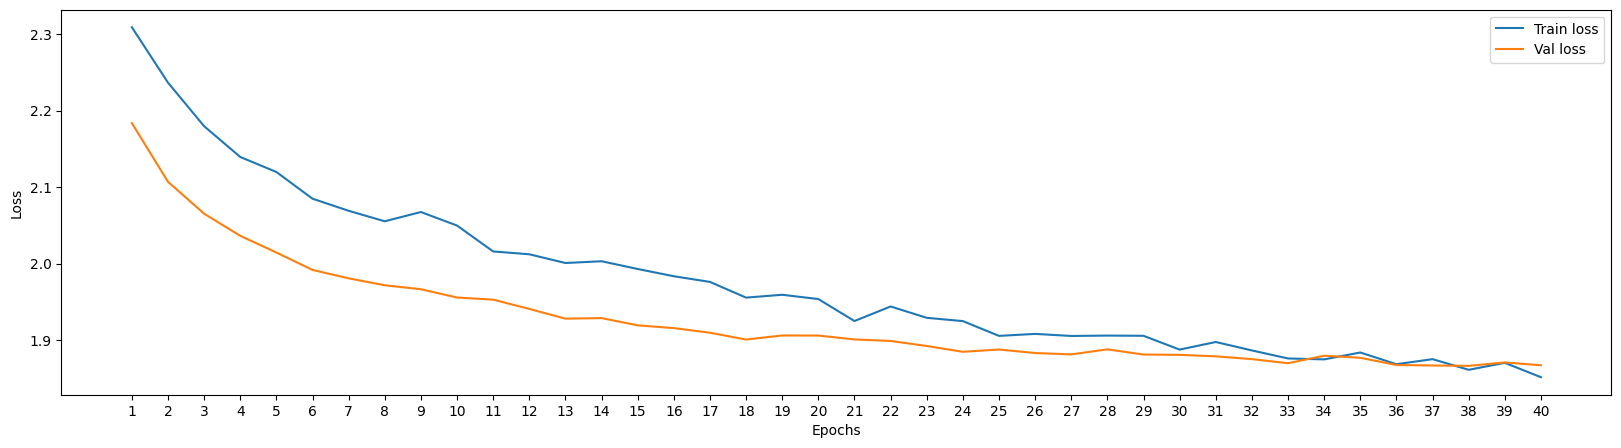

In [41]:
import matplotlib.pyplot as plt

# Funcion para graficar training_loss y eval_loss
def plotLoss(log_history):
    # INPUT:
    #    log_history: trainer.state.log_history
    log_history = trainer.state.log_history
    df_history = pd.DataFrame(log_history)
    set_train_loss = []
    set_val_loss = []
    # Obtener el numero de epocas
    epochs = int(df_history['epoch'].max())
    # Almacenar por epoca
    for i in range(1,epochs+1):
        #Obtener el indice de la primera ocurrencia de EPOCH
        index_val = df_history.loc[(df_history['epoch']==i),'loss'].index.tolist()[0]
        # Se le resta 1 al index de evaluacion, por que se vio en el dataframe que en uno anterior esta el dato de train_loss
        index_train = index_val-1
        # New loss
        train_loss = df_history.loc[index_train,'loss']
        val_loss = df_history.loc[index_val,'eval_loss']
    
        # Add new loss
        set_train_loss.append(train_loss)
        set_val_loss.append(val_loss)

    # Plot
    loss_index = range(1, len(set_train_loss) + 1)
    
    plt.figure(figsize=(20, 5))
    plt.plot(loss_index, set_train_loss, label='Train loss')
    plt.plot(loss_index, set_val_loss, label='Val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, len(set_train_loss) + 1))
    # Trazar una línea punteada en x=4
    #plt.axvline(x=13, color='purple', linestyle='--', label='Interception')
    #plt.axvline(x=39, color='yellow', linestyle='--', label='Earlystopping')
    plt.legend()
    plt.show()

plotLoss(trainer.state.log_history)

In [42]:
end = datetime.datetime.now()
print('Tiempo Final:', end.strftime("%m/%d/%Y, %H:%M:%S"))
print('Demoro en total:', end-start)

Tiempo Final: 04/29/2024, 14:22:09
Demoro en total: 4 days, 7:11:29.088037


In [43]:
# Pesos despues del entrenamiento
for name, param in model.named_parameters():
    print('------------------')
    print("=== Name: ",name)
    print('------------------')
    print(param)

------------------
=== Name:  bert.embeddings.word_embeddings.weight
------------------
Parameter containing:
tensor([[ 0.0093, -0.0205,  0.0447,  ..., -0.0483, -0.0463,  0.0023],
        [ 0.0062, -0.0326,  0.0464,  ..., -0.0632, -0.0596, -0.0063],
        [-0.0138, -0.0493,  0.0093,  ..., -0.0138, -0.0428, -0.0009],
        ...,
        [ 0.0775, -0.0109,  0.0108,  ..., -0.0153, -0.0487,  0.0007],
        [ 0.0210, -0.0360,  0.0549,  ..., -0.0338, -0.0591,  0.0032],
        [-0.0074, -0.0173,  0.0024,  ..., -0.0348, -0.0257, -0.0028]],
       device='cuda:0')
------------------
=== Name:  bert.embeddings.position_embeddings.weight
------------------
Parameter containing:
tensor([[-0.0378,  0.0038, -0.0299,  ...,  0.0320,  0.0005, -0.0145],
        [-0.0175, -0.0197,  0.0336,  ...,  0.0171,  0.0136, -0.0134],
        [ 0.0025, -0.0349,  0.0170,  ..., -0.0021,  0.0155, -0.0122],
        ...,
        [ 0.0081,  0.0739,  0.0219,  ..., -0.0117,  0.0033,  0.0668],
        [ 0.0169,  0.0470

In [44]:
# Ruta del mejor modelo guardado
best_ckpt_path = trainer.state.best_model_checkpoint
best_ckpt_path

'./result/code_selfsupervised_BERTimabauBase-UTLCapps-1lastlayersdefreeze-LR1e4/checkpoint-369512'